## Generate sample text segments for use of language model and for prediction

Note: intended to run on 8GB+ CUDA-capable machine

In [2]:
%matplotlib inline

In [3]:
import pymongo
import random
import numpy as np

random.seed(42)

In [ ]:
MONGODB_PORT = 25541

# return this percent of the snippets
snippetSamplePct = 0.01
assert(snippetSamplePct < 1.)
output_filename = 'snippets_sample.1pct.tsv' # even though there's only one field, call it tab-seperated, because commas are in the data.

# create a sample of p% of the data, excluding training and holdout sets
with pymongo.MongoClient('localhost', MONGODB_PORT) as mclient:
    mdb = mclient.snippetdb
    msnippets = mdb.snippets
    #msnippets.create_index([('holdout', pymongo.ASCENDING)])
    #msnippets.create_index([('train_set', pymongo.ASCENDING)])
    
    #nSnippets = msnippets.count_documents({'holdout': {'$exists': False}, 'train_set': {'$exists': False}})
    #bernoulli_draw = np.random.binomial(size=nSnippets, n=1, p = 0.1)
    
    doc_cursor = msnippets.find({'holdout': {'$exists': False}, 'train_set': {'$exists': False}})
    
    with open(output_filename, 'w') as snippet_file:
        for i, doc in enumerate(doc_cursor):
            if i%10000 == 0: 
                print('processing record ' + str(i))
            if np.random.binomial(1, snippetSamplePct):
                # bernoulli draw comes up heads, save this one
                snippet = " ".join([doc['snippet_part1'], doc['snippet_part2'], doc['snippet_part3']])
                snippet_file.write(snippet + '\n')

## Train a language model based upon this snippet sample

In [1]:
from fastai.text import *
bs = 64 # size of minibatch
# written with fastai v1.0.42

TODO: increase vocab size? fine tune tokenization?
    current method uses 6510/8110 MB video ram
    
Note: this code runs on demon

In [9]:
# Yay, my new way works!
# (this is using an addition to fastai that will be incorporated in 1.0.44)
data_lm_test = TextLMDataBunch.from_csv('snippet_samples', sample_filename, header=None, delimiter='\t', col_names=['text'], valid_pct=0.005, min_freq=4, text_cols=['text'])

In [113]:
# this is the way that works in v1.0.42 of fastai
valid_pct = 0.005
path = 'snippet_samples'
df = pd.read_csv(path + '/' + sample_filename, header = None, delimiter='\t', names=['text'])
#df = pd.read_csv(Path(path)/csv_name, header=header)
df = df.iloc[np.random.permutation(len(df))]
cut = int(valid_pct * len(df)) + 1
train_df, valid_df = df[cut:], df[:cut]

data_lm = TextLMDataBunch.from_df(path, train_df, valid_df, text_cols='text', min_freq=4)
data_lm.save('data_lm')

In [114]:
print(data_lm.vocab.itos[:15])
print(len(data_lm.vocab.itos))

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.', 'the', ',', 'to', 'and', 'a', '>']
43671


In [117]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj at xxmaj edward xxmaj jones , it 's how we make sense of investing . xxmaj ask me what it 's like to get your xxmaj st night 's sleep every night . xxmaj why not talk to someone who 's sleeping on the most highly recommended bed in xxmaj america ? xxmaj ask me about my tempur - pedic . xxmaj ask me how fast i fall"
1,she is playing fast and loose with facts to keep her supporters riled up with a policy he cares about . xxbos > xxmaj interesting to me it has fallen on deaf ears on both sides of the aisle . > i 'm still hopeful this is some business tax reform in 2015 xxmaj charles . xxmaj even a president said we could do something on the corporate side and
2,") . xxmaj too many times i feel bloated , gassy , uncomfortable with xxunk . xxbos i looked up and said , oh , heavenly father , you 're the man . xxmaj like , four years ago , i could n't see this . xxmaj now you fight on . xxmaj national xxmaj championships and now i 'm sitting here about to play xxmaj michigan . xxmaj after"
3,"from foreign governments and of the government offers the xxup u.s. xxbos > xxmaj what about xxmaj john mccain and other senators talking about taking an air strike against xxmaj syria ? xxmaj your response to that ? > xxmaj well , i was on the hill the other day , before we put the full page op xxmaj ed , as it were in the ' washington post '"
4,- reporter who live just a couple of blocks away . xxmaj look at that plume of smoke . xxmaj he says firefighters had just arrived there on the scene of this collapsed building when he whipped out his cell phone and started snapping these pictures . xxmaj that i - reporter is xxmaj don xxmaj nicholson . xxmaj he 's good enough to hop on the phone and join


In [115]:
# Transfer learning from wikipedia-trained LM. drop_mult reduced from 1 to avoid underfitting.
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


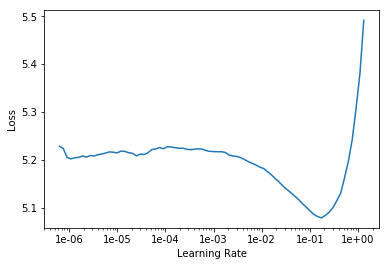

In [118]:
learn.recorder.plot(skip_end=10)

In [119]:
learn.fit_one_cycle(2, max_lr=3e-2, moms=(0.8,0.7)) # wd=0.01

epoch,train_loss,valid_loss,accuracy
1,4.515438,4.263107,0.268718
2,4.163457,3.929845,0.297628


In [120]:
learn.save('lm_fit_head2')

In [121]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


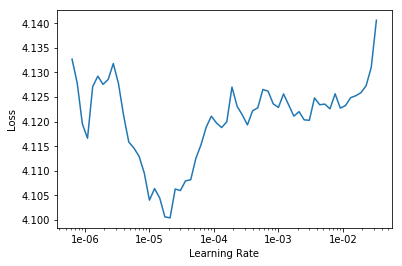

In [124]:
learn.recorder.plot(skip_end=30)

In [125]:
learn.fit_one_cycle(2, max_lr=slice(8e-6, 2e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy
1,3.950201,3.784678,0.314611
2,3.753853,3.605458,0.334809


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [126]:
learn.save('lm_fine_tune2_drop_mult0.5_2epoch')

In [127]:
learn.fit_one_cycle(4, max_lr=slice(8e-6, 2e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy
1,3.874056,3.716953,0.323801
2,3.806500,3.658494,0.330306
3,3.690896,3.545164,0.344522
4,3.606456,3.498101,0.350370


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [128]:
learn.save('lm_fine_tune2_drop_mult0.5_6epoch')

In [130]:
TEXT = "> I just didn't"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

> I just didn't think i were going to have a chance to take some of the spin off the couch . xxbos > xxmaj what i think is a lot of money , i do n't know if they will go down the
> I just didn't need to start thinking about all that stuff . xxmaj but the fact that we were at the end of the day and we had to make that decision , i think we are going to be looking at the


In [131]:
learn.fit_one_cycle(6, max_lr=slice(8e-6, 2e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy
1,3.713100,3.580732,0.341225
2,3.772532,3.629066,0.334885
3,3.735081,3.582492,0.342251
4,3.654706,3.516150,0.349853
5,3.577202,3.458276,0.357047
6,3.535970,3.439400,0.359707


In [132]:
learn.save('lm_fine_tune2_drop_mult0.5_12epoch')

In [133]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


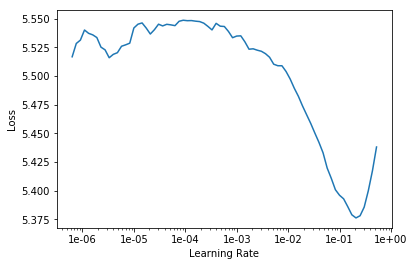

In [135]:
learn.recorder.plot(skip_end=15)

In [136]:
learn.fit_one_cycle(2, max_lr=2e-2, moms=(0.8,0.7)) # wd=0.01

epoch,train_loss,valid_loss,accuracy
1,4.655230,4.230515,0.269675
2,4.402208,4.009477,0.287022


In [137]:
learn.save('lm_fit_head3')

In [138]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


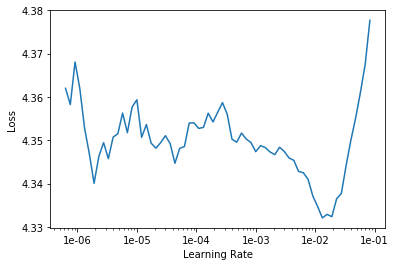

In [141]:
learn.recorder.plot(skip_end=25)

In [142]:
learn.fit_one_cycle(5, max_lr=slice(8e-4, 2e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy
1,3.999399,3.778786,0.318170
2,3.899367,3.684315,0.331129
3,3.787424,3.575407,0.344401
4,3.653477,3.466707,0.357085
5,3.579921,3.425743,0.362819


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [143]:
learn.save('lm_fine_tune3_5epoch')

In [144]:
learn.fit_one_cycle(1, max_lr=slice(8e-4, 2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.670648,3.461430,0.359235


In [107]:
# save encoder from the learner (the part that learns the language)
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1) #drop_multi=0.3
learn.load('lm_fine_tune3_5epoch')
learn.save_encoder('lm_fine_tuned3_enc')

## Now use the language model's encoder to improve classification. 
## Train a new classifier from our labeled data

In [108]:
data_lm = TextLMDataBunch.load('snippet_samples', 'data_lm')

In [109]:
# these approaches won't work...

# data_clas = (TextList.from_folder('labeled_data/label_category', vocab=data_lm.vocab)
#              #grab all the text files in pat
#              .split_by_fname_file('label_category_valid.tsv')
#              #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
#              #.label_from_folder(classes=['neg', 'pos'])
#              .label_from_df(cols=1)
#              #label them all with their folders
#              .databunch(bs=bs))

# data_clas = TextLMDataBunch.from_csv('labeled_data/label_category', 'label_category_train.tsv', 'label_category_valid.tsv')

In [110]:
# load our labeled data into a TextClasDataBunch
path = Path('labeled_data')
fold = '0'
path /= 'fold_' + fold
groupname = 'label_category'
train_df = pd.read_csv(path/groupname/(groupname+'_train-truecase.tsv'), header=None, delimiter='\t', names=['label','text'])
valid_df = pd.read_csv(path/groupname/(groupname+'_valid-truecase.tsv'), header=None, delimiter='\t', names=['label','text'])

data_clas = TextClasDataBunch.from_df(path, train_df, valid_df, vocab=data_lm.vocab, text_cols='text', label_cols='label', bs=bs)
data_clas.save('fold_'+fold+'-'+groupname+'_clas')

In [111]:
train_df.head()

,label,text
0,transitions,"> Plus for the first time, an entire state set..."
1,ads,> You know it is Martin Luther King day go ahe...
2,ads,"Because when brands compete, you save during m..."
3,ads,We'll be right back live on the 100th birthday...
4,ads,> American rapidly turning into a welfare stat...


In [112]:
valid_df.head()

,label,text
0,ads,"> Up next, a new round of keystone protest is ..."
1,current_events,The queen after place of coronation followed b...
2,ads,"Ya know, your rates and fees aren't exactly co..."
3,ads,"A lot of companies might answer 'um' or, 'no c..."
4,ads,Seek immediate medical care for unexpected sig...


In [113]:
data_clas.show_batch()

text,target
xxbos > i think -- i do n't know what we 're going to expect . xxmaj clearly there 's three players out there on the stage and they determine a lot of what 's going to happen and i think a lot of it is going to depend on how the moderator conducts it and how xxmaj congressman xxmaj ryan does . xxmaj congressman xxmaj ryan and vice president,elections_soft
"xxbos > xxbell every day , when you 're walking down the street xxbell xxbell everybody that you meet has an original point of view xxbell xxbell and i say , hey xxbell hey ! xxbell what a wonderful kind of day xxbell xxbell if we could learn to work and play xxbell xxbell and get along with each other xxbell xxbell you got to listen to your heart ,",entertainment
"xxbos xxbell xxbell xxup xxunk xxup xxunk , xxunk xxup xxunk xxup xxunk , xxbell xxbell xxwrep 4 xxup xxunk al xxunk ( c ) s , xxbell xxbell xxup xxunk xxup xxunk , xxunk xxup xxunk xxup xxunk , xxbell xxbell xxwrep 4 xxup xxunk al xxunk ( c ) s , xxbell xxbell xxup xxunk xxup xxunk , xxunk xxup xxunk xxup xxunk , xxbell xxbell xxup xxunk",ads
"xxbos xxmaj if you 've had a heart attack be sure to talk to your doctor before you begin an aspirin regimen . xxbell i found a happy place xxbell xxbell it 's written on my face xxbell xxbell we 're singin ' , we 're singin ' xxbell xxbell i found a happy place xxbell xxbell a rather happy place xxbell xxbell i 'm singin ' , i 'm",ads
xxbos 98 xxmaj medal events in total and perhaps the event which might get the most attention is women 's ski jumping because we 've never had women 's ski jumping in the xxmaj olympics before . xxmaj they had a lodge battle to get in . xxmaj they were refused entry four years ago in xxmaj vancouver . xxmaj they went to court to get in the games and,sports


In [114]:
learn = text_classifier_learner(data_clas, drop_mult=1.0)
learn.load_encoder('../../../snippet_samples/models/lm_fine_tuned3_enc')
learn.freeze()

In [115]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


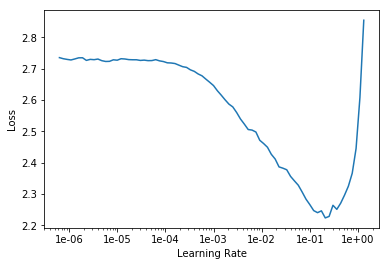

In [116]:
learn.recorder.plot()

In [117]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.741786,1.598923,0.591362


In [118]:
learn.save('first')

In [119]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy
1,1.419402,1.242456,0.624585


In [120]:
learn.save('second')

In [121]:
learn.load('second');

In [122]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy
1,1.185668,1.089492,0.661130


In [123]:
learn.save('third')

In [124]:
learn.load('third');

In [125]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.065894,1.057384,0.664452
2,1.029392,1.062633,0.674419


In [126]:
learn.save('fine_tuned')

In [127]:
learn.load('fine_tuned')
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.077359,1.041728,0.681063
2,1.051264,1.026283,0.681063


In [128]:
learn.save('fine_tuned2')

In [131]:
learn.load('fine_tuned2')
# from prior run, this was declining
learn.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.041981,1.032400,0.674419
2,1.025384,1.021186,0.667774


In [130]:
learn.save('fine_tuned3')